# Libraries import

In [30]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"
# %cd /content/gdrive/My Drive/Colab Notebooks

In [31]:
# # uncomment this cell for first run to install the packages.
# !pip install quandl
# !pip install ta 
# !pip install pycaret
# !pip install kats
# !pip install git+https://github.com/ourownstory/neural_prophet.git
# !pip install -U prophet
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U pmdarima


# !pip --version
# !pip install quandl
# !pip install  statsmodels
# !pip install pycaret
# !pip install kats
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U sklearn
# !pip install ta 
# !pip install -U pmdarima

In [32]:
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
from sklearn.model_selection import train_test_split
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import random
import sys
import itertools
import warnings

warnings.filterwarnings('ignore')

In [33]:
from pycaret.regression import *
import copy
# import plotly.express as px

In [34]:
from kats.consts import TimeSeriesData

In [35]:
pd.set_option('display.max_columns', None)

In [36]:
quandl.ApiConfig.api_key = "2At3atzXCrMx_BXfkyz7"
# 6b7jcHuxwW7Wot1kyFNS

# Data to be used

In [37]:
metadata = pd.read_csv('BSE_metadata.csv')
metadata.head()

,code,name,description,refreshed_at,from_date,to_date
0,BOM500002,ABB India Limited EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
1,BOM500003,AEGIS LOGISTICS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
2,BOM500008,AMARA RAJA BATTERIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
3,BOM500009,AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
4,BOM500010,HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,1/3/1992,1/18/2021


## Utility variables and functions

In [38]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [39]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [40]:
start_date = '2020-03-02'
end_date = '2021-03-23'

In [41]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = allSymbols):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [42]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
#     print(result)
    out = pd.Series(result[0:4], index=label)
    out['Stock Name'] = getStockNameFromStockCode(title)
    out['Stock Code'] = title
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
#     print(out)
    if(result[1]<0.05):
        return out, 'Stationary'
    else:
        return out, 'Non-Stationary'

In [43]:
stockMetadata = metadata[metadata['code'].isin(allSymbols)]
stockMetadata.head()

,code,name,description,refreshed_at,from_date,to_date
70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021
121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021


In [44]:
print(stockMetadata.shape)
print(stockMetadata[stockMetadata['code'].isin(stocks)].shape)
print(stockMetadata[stockMetadata['code'].isin(indices)].shape)

(21, 6)
(15, 6)
(6, 6)


## Map Index to  stocks

In [45]:
stockMetadata.loc[:, 'isStock'] = 0
stockMetadata.loc[:, 'Index'] = ''

stockMetadata.loc[stockMetadata['code'].isin(stocks), 'isStock'] = 1
stockMetadata.reset_index(inplace=True)

In [46]:
stockMetadata.loc[stockMetadata['code'].isin(healthcare), 'Index'] = BSE_HEALTHCARE
stockMetadata.loc[stockMetadata['code'].isin(banking), 'Index'] = BSE_BANKEX
stockMetadata.loc[stockMetadata['code'].isin(metals), 'Index'] = BSE_METAL
stockMetadata.loc[stockMetadata['code'].isin(auto), 'Index'] = BSE_AUTO
stockMetadata.loc[stockMetadata['code'].isin(it), 'Index'] = BSE_Information_Technology

In [47]:
stockMetadata.head()

,index,code,name,description,refreshed_at,from_date,to_date,isStock,Index
0,70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021,1,SI0800
1,104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021,1,SIBANK
2,121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1000
3,133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1200
4,146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SIBANK


In [48]:
stockMetadata['isStock'].value_counts()

1    15
0     6
Name: isStock, dtype: int64

# Code to download the data from quandl. 

In [49]:
# # download the required data - needed only 1 time
# i=0
# code = f'BSE/{stockMetadata.loc[i, "code"]}'
# dataset = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
# dataset['StockName']=stockMetadata.loc[i, 'name']
# dataset['code'] = stockMetadata.loc[i, "code"]
# dataset['isStock'] = stockMetadata.loc[i, "isStock"]
# dataset['Index'] = stockMetadata.loc[i, "Index"]
# for i in range(1, len(stockMetadata)):
#     code = f'BSE/{stockMetadata.loc[i, "code"]}'
#     temp = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
#     temp['StockName']=stockMetadata.loc[i, 'name']
#     temp['code'] = stockMetadata.loc[i, "code"]
#     temp['isStock'] = stockMetadata.loc[i, "isStock"]
#     temp['Index'] = stockMetadata.loc[i, "Index"]
# #     print( stockMetadata.loc[i, "Index"])
#     dataset = dataset.append(temp)
# dataset.to_csv('data.csv')
# dataset.head()

In [ ]:
dataset = pd.read_csv('data.csv')
dataset.head()

In [ ]:
dataset.info()

### Verify the min and max of dates of all selected stocks and indices

In [ ]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges.columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']
dateRanges

In [53]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges['Stock Code']==stockCode, 'Stock Name'].values[0].replace('EOD Prices', '');

In [ ]:
data = dataset.set_index('Date')
data.head()

### Populate dictionary to hold individual Stock Data

In [55]:
# ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]

### View null values in the data 

In [ ]:
getNullValuesForSetOfStocks()

# Deriving Technical indicators 

### MACD

In [57]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [58]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

### RSI - Relative Strength Index

In [59]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [60]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

### ATR

In [61]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [62]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

### Bollinger band

In [63]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [64]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

### OBV

In [65]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [66]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

### ADX

In [67]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [68]:
# ADX
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

In [ ]:
getNullValuesForSetOfStocks()

# Removing Extra Columms

In [70]:
OriginalScriptWiseData = ScriptWiseData
for symbol in allSymbols:
    ScriptWiseData[symbol] = ScriptWiseData[symbol][['Close']+TechnicalIndicators]

## Dropping null values

In [71]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
#     ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna()    

In [72]:
# ScriptWiseData['BOM500180'][ScriptWiseData['BOM500180']['MACD'].isna()]
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD.,DIVI'S LABORATORIES LTD.,DR.REDDY'S LABORATORIES LTD.,HDFC Bank Ltd,ICICI BANK LTD.,KOTAK MAHINDRA BANK LTD.,TATA STEEL LTD.,JSW STEEL LTD.,HINDALCO INDUSTRIES LTD.,BAJAJ AUTO LTD.,TATA MOTORS LTD.,MARUTI SUZUKI INDIA LTD.,INFOSYS LTD.,TATA CONSULTANCY SERVICES LTD.,WIPRO LTD.,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RSI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,27,27,27
ATR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3829,3829,388,1184,1184,20
MACD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,25,25,25,25,25
adx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5255,5255,4757,5255,5255,0
OBV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282


In [73]:
finalDateRanges =pd.DataFrame(columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']) 
for s in stocks:
    r = [s, getStockNameFromStockCode(s), ScriptWiseData[s].index.min(),  ScriptWiseData[s].index.max()]
    finalDateRanges.loc[len(finalDateRanges)] = r
finalDateRanges

,Stock Code,Stock Name,First Date,Last Date
0,BOM524715,SUN PHARMACEUTICAL INDUSTRIES LTD.,2000-02-10,2021-03-23
1,BOM532488,DIVI'S LABORATORIES LTD.,2003-04-23,2021-03-23
2,BOM500124,DR.REDDY'S LABORATORIES LTD.,2000-02-10,2021-03-23
3,BOM500180,HDFC Bank Ltd,2000-02-10,2021-03-23
4,BOM532174,ICICI BANK LTD.,2000-02-10,2021-03-23
5,BOM500247,KOTAK MAHINDRA BANK LTD.,2000-02-10,2021-03-23
6,BOM500470,TATA STEEL LTD.,2000-02-10,2021-03-23
7,BOM500228,JSW STEEL LTD.,2000-02-10,2021-03-23
8,BOM500440,HINDALCO INDUSTRIES LTD.,2000-02-10,2021-03-23
9,BOM532977,BAJAJ AUTO LTD.,2008-07-02,2021-03-23


# ADF Test for closing price

In [74]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Close, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Close, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTest.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD.,BOM524715,-5.02575,1.97306e-05,0,5253,-3.4316,-2.86209,-2.56706,Stationary
DIVI'S LABORATORIES LTD.,BOM532488,-3.57137,0.0063325,32,4424,-3.43183,-2.86219,-2.56712,Stationary
DR.REDDY'S LABORATORIES LTD.,BOM500124,-0.0817256,0.951229,28,5226,-3.4316,-2.86209,-2.56706,Non-Stationary
HDFC Bank Ltd,BOM500180,-2.22396,0.197665,0,5254,-3.4316,-2.86209,-2.56706,Non-Stationary
ICICI BANK LTD.,BOM532174,-2.65894,0.0814161,1,5252,-3.4316,-2.86209,-2.56706,Non-Stationary


# Train test and validation split

In [75]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

# Code Addition Tavish -----------------------------------------------

#ARIMA 

### AutoARIMA DataFrame


In [152]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [157]:
#AutoArimaResults = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks)
#AutoArimaResults = pd.read_csv('Outputs/AutoArimaResults.csv',index_col='Unnamed: 0')


In [175]:
AutoArimaResults

,p Closing Values,d Closing Values,q Closing Values,p N Closing Values,d N Closing Values,q N Closing Values,p Closing Percentage,d Closing Percentage,q Closing Percentage
BOM524715,0,1,1,NaN,NaN,NaN,1,0,2
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,2,0,4
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1


In [176]:
AutoArimaResults.to_csv('Outputs/AutoArimaResults.csv')

In [160]:
def CalculateAutoArima(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResults.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], maxiter = 1000)
        AutoArimaResults.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResults.loc[stockcode, [p, d, q]])

### Common Functions

In [80]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse

## remove the string conversion

In [131]:
def errorEvaluation(actual, pred):
    RMSE = mean_squared_error(actual, pred, squared=False)
    MAPE = mean_absolute_percentage_error(actual,pred)
    R2 = r2_score(actual,pred)
    Noise = float(pred.diff().abs().mean())
    return [RMSE, MAPE, R2, Noise]


In [89]:
def modified_prediction_frame(_df_pred, index):
    _df_pred = _df_pred.to_frame()
    _df_pred['Date'] = index
    pd.to_datetime(_df_pred['Date'])
    _df_pred.set_index('Date', inplace=True)
    _df_pred.rename(columns={0 : 'Predicted'}, inplace=True)
    return _df_pred

## ARIMA for Closing Values 

# Tavish - Fix this one too. 

### Generic Function For ARIMA Closing Prices

In [163]:
def ARIMA_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data):
    print("Modeling for the Stock: {}".format(StockCode))

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

    print("ADF Test for the given series.")
    adf, Stationarity = adf_test(train_data[feature], title=StockCode)
    print(adf)
    print('----------------------------------------------------------------------------')
    Results.loc[StockCode,'Stationarity'] = Stationarity
    model = ARIMA(train_data[feature], order = Order)

    results = model.fit()
    print(results.params)
    print("Order: " + str(Order) )
    print('---------------------------------------------------------------------------')
    Results.loc[StockCode, 'Order'] = str(Order)

    predictions = results.predict(start = start, end = end, typ ='levels')
    predictions = modified_prediction_frame(predictions, test_data[feature].index)

    errorEval = errorEvaluation(test_data[feature], predictions)
    RMSE, MAPE, R2, Noise = errorEval
    Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval
    print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
    print('---------------------------------------------------------------------------')

    print('Description of the Predicted Data')
    print(predictions.describe())
    pred_mean = predictions.mean(numeric_only=True)
    Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
    print('---------------------------------------------------------------------------')

    print('Description of the Actual Data')
    print(test_data[feature].describe())
    Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
    return predictions


In [164]:
ArimaModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
feature = 'Close'
for stock in stocks:
    print("Working for Stock - {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    Order = CalculateAutoArima(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
    ARIMA_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults, Order=Order, train_data=train_data, test_data=test_data)
    break

In [166]:
ArimaModelPricesResults.to_csv('Outputs/ArimaModelPricesResults.csv')

## ARIMA for Normalized Closing Price

### Normalizing the Values  - Normalized_Prices

# TAVISH  - CREATE A COPY HERE

In [167]:
normalized_columns = ['Normalized Closing', 'Normalized RSI', 'Normalized ATR', 'Normalized MACD', 'Normalized ADX', 'Normalized OBV']
normalized_TechnicalIndicators = ['Normalized RSI', 'Normalized ATR', 'Normalized MACD', 'Normalized ADX', 'Normalized OBV']


In [ ]:
# first value normalization
for stock in stocks:
    cols = list(ScriptWiseData[stock].columns)
    for count in range(len(cols)):
      benchmark_prices = ScriptWiseData[stock][cols[count]].iloc[0]
      ScriptWiseData[stock][normalized_columns[count]] = ScriptWiseData[stock][cols[count]].div(benchmark_prices).mul(100)
        

###  ARIMA Normalized Closing Prices

In [145]:
ArimaModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Normalized Closing'
    Order = CalculateAutoArima(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
    ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data)

In [ ]:
ArimaModelPricesResults_Norm.to_csv('Outputs/ArimaModelPricesResults_Norm.csv')

## ARIMA Model For Returns

### Convert Closing price to percentage change



> revisit normalization for this section - consider normalizing in range -1 and 1 --- Not done yet



In [172]:
for s in stocks:
    ScriptWiseData[s]['Stock_Returns'] = ScriptWiseData[s]['Close'].pct_change(1).mul(100) 
    ScriptWiseData[s] = ScriptWiseData[s][1:] # Because of NAN first value

In [ ]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Stock_Returns, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Stock_Returns, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.head()

### ARIMA for percentage Returns

In [173]:
ArimaModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
        Order = CalculateAutoArima(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
        ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data)
    except Exception as e:
        print(e)
    

In [178]:
ArimaModelPricesResults_Returns

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,Stationary,"(1, 0, 2)",2.41811,1.01661,-0.00503779,0.000627395,0.03046721759811536,0.20573864798210306
BOM532488,Stationary,"(3, 0, 1)",2.37179,1.43882,-0.00270989,0.000307765,0.106208433634353,0.22024935679929103
BOM500124,Stationary,"(0, 0, 0)",2.25446,1.03235,-0.00371939,0,0.043644919963448096,0.18088231861858162
BOM500180,Stationary,"(1, 0, 1)",2.65192,1.02312,-0.000856225,0.00032133,0.07198786485340858,0.12566854955618048
BOM532174,Stationary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,Stationary,"(0, 0, 1)",2.91412,1.06271,-8.85099e-05,0.000186637,0.10389042450390948,0.0901047802483421
BOM500470,Stationary,"(2, 0, 2)",3.11018,1.01069,-0.00788678,0.00350141,0.0564316054197651,0.3173045225208098
BOM500228,Stationary,"(0, 0, 0)",3.11693,1.62784,-0.00572146,0,0.5238741364812858,0.2887804435159547
BOM500440,Stationary,"(2, 0, 2)",3.68215,0.985914,-0.00914721,0.00181664,0.027243191666161556,0.36871118873150094
BOM532977,Stationary,"(0, 0, 1)",2.43428,1.1739,0.000657975,0.000842998,0.08611727899873031,0.13360405849851478


In [177]:
ArimaModelPricesResults_Returns.to_csv('Outputs/ArimaModelPricesResults_Returns.csv')

#ARIMAX

### AutoARIMA DataFrame


In [179]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [181]:
#AutoArimaResultsForArimax = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks)
AutoArimaResultsForArimax = pd.read_csv('Outputs/AutoArimaResultsForArimax.csv',index_col='Unnamed: 0')
AutoArimaResultsForArimax

,p Closing Values,d Closing Values,q Closing Values,p N Closing Values,d N Closing Values,q N Closing Values,p Closing Percentage,d Closing Percentage,q Closing Percentage
BOM524715,0,1,1,0,1,1,1,0,2
BOM532488,1,1,3,1,1,3,3,0,1
BOM500124,2,1,2,1,1,0,0,0,0
BOM500180,0,1,0,0,1,0,1,0,1
BOM532174,2,1,1,2,1,1,2,0,4
BOM500247,1,1,2,1,1,2,0,0,1
BOM500470,2,1,2,2,1,2,2,0,2
BOM500228,0,1,0,0,1,0,0,0,0
BOM500440,0,1,0,0,1,0,2,0,2
BOM532977,1,1,2,1,1,2,0,0,1


In [182]:
def CalculateAutoArimaForArimax(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResultsForArimax.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], exog = data[TechnicalIndicators], maxiter = 1000)
        AutoArimaResultsForArimax.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResultsForArimax.loc[stockcode, [p, d, q]])

##Generic Function for ARIMAX

# TAVISH - FIX THIS SHIT - EXOG VARIABLE IS INCORRECT

In [184]:
def ARIMAX_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data, extra_indicators):
    print("Modeling for the Stock: {}".format(StockCode))

    start = len(train_data)
    end = len(train_data) + len(test_data) - 1

    print("ADF Test for the given series.")
    adf, Stationarity = adf_test(train_data[feature], title=StockCode)
    print(adf)
    print('----------------------------------------------------------------------------')
    Results.loc[StockCode,'Stationarity'] = Stationarity

    exog_train = train_data[extra_indicators]
    model = ARIMA(endog = train_data[feature], exog = exog_train , order = Order)
    results = model.fit()
    print(results.params)
    print("Order: " + str(Order) )
    print('---------------------------------------------------------------------------')
    Results.loc[StockCode, 'Order'] = str(Order)

    exog_test = test_data[extra_indicators]
    predictions = results.predict(start = start, end = end, typ ='levels', exog=exog_test)
    predictions = modified_prediction_frame(predictions, test_data[feature].index)

    predictions.plot(figsize=(12,8), legend=True)
    test_data[feature].plot(figsize = (12,8), legend=True)

    errorEval = errorEvaluation(test_data[feature], predictions)
    RMSE, MAPE, R2, Noise = errorEval
    Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval

    print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
    print('---------------------------------------------------------------------------')

    print('Description of the Predicted Data')
    print(predictions.describe())
    pred_mean = predictions.mean(numeric_only=True)
    Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
    print('---------------------------------------------------------------------------')

    print('Description of the Actual Data')
    print(test_data[feature].describe())
    Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
    return predictions

## ARIMAX for Closing Prices

In [185]:
ArimaxModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [186]:
ArimaxModelPricesResults

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Working for Stock BOM524715
Modeling for the Stock: BOM524715
ADF Test for the given series.
ADF test statistic                                 -4.80709
p-value                                         5.27124e-05
# lags used                                               0
#observations                                          4988
Stock Name              SUN PHARMACEUTICAL INDUSTRIES LTD. 
Stock Code                                        BOM524715
critical value (1%)                                -3.43166
critical value (5%)                                -2.86212
critical value (10%)                               -2.56708
dtype: object
----------------------------------------------------------------------------
const           -1.931924e+00
RSI              1.495294e+01
ATR             -3.789650e-01
MACD            -1.627394e-01
adx             -2.702807e-01
OBV              2.236334e-08
ma.L1.D.Close    3.823328e-02
dtype: float64
Order: (0, 1, 1)
----------------------------------

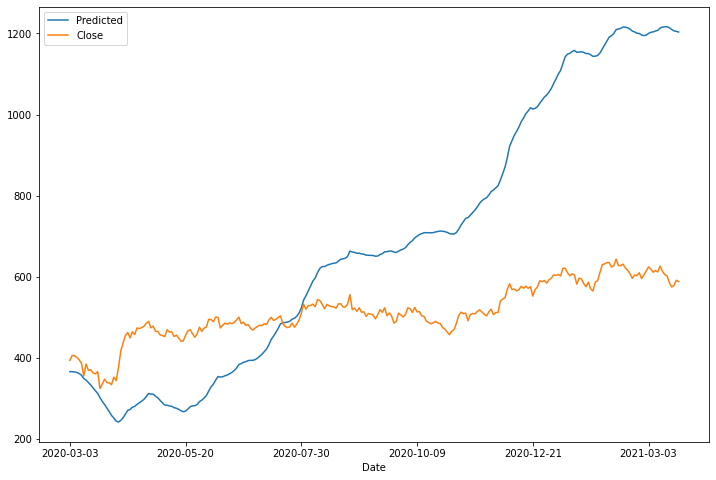

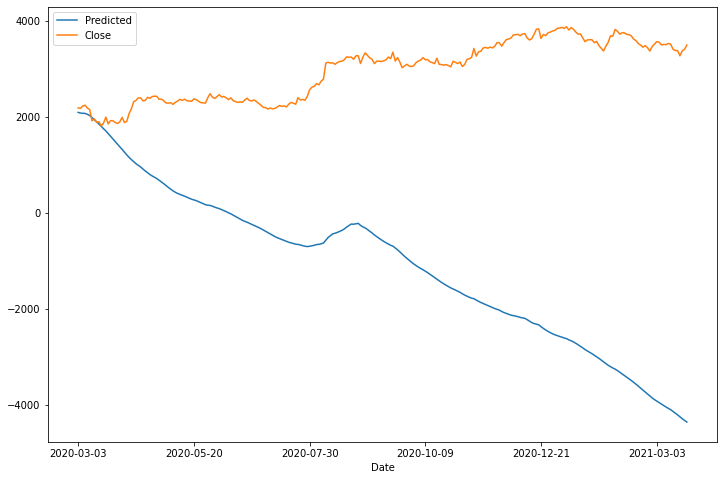

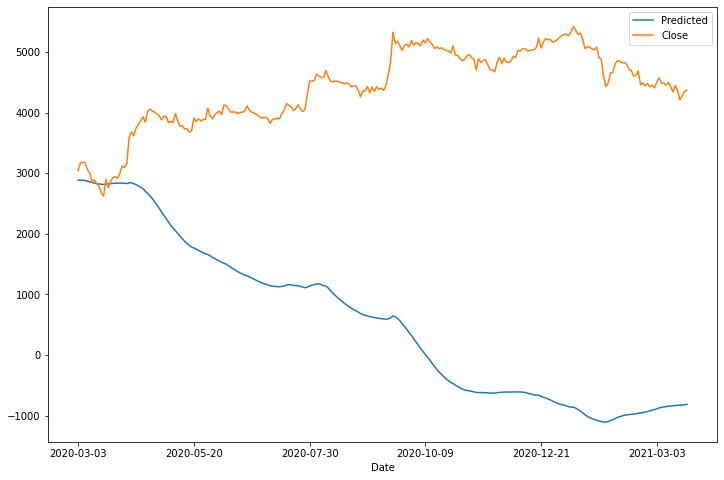

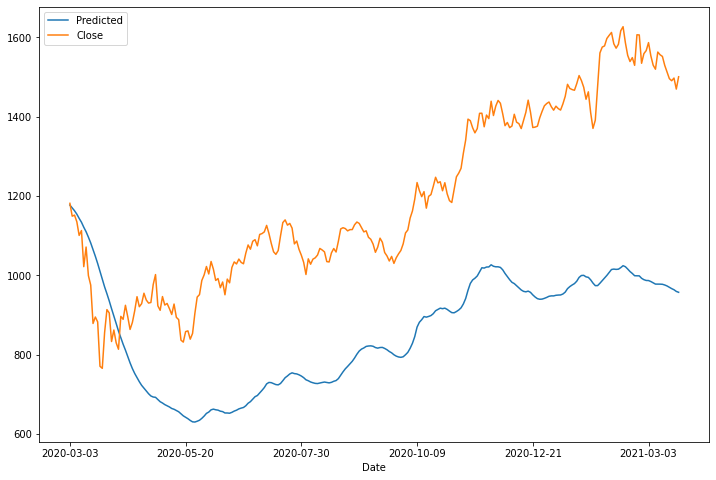

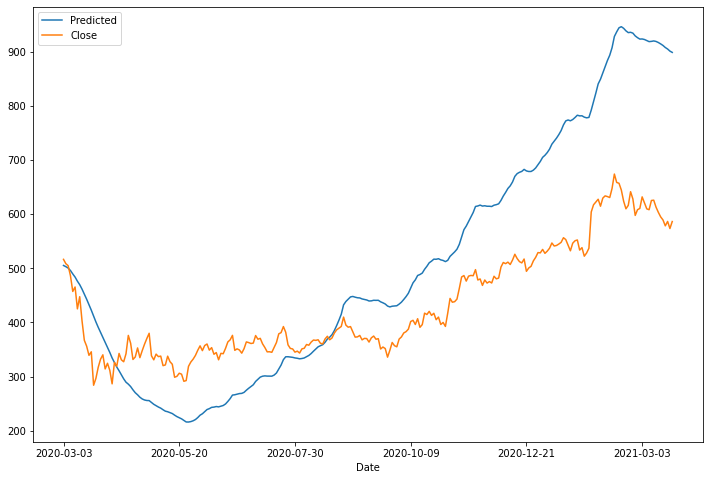

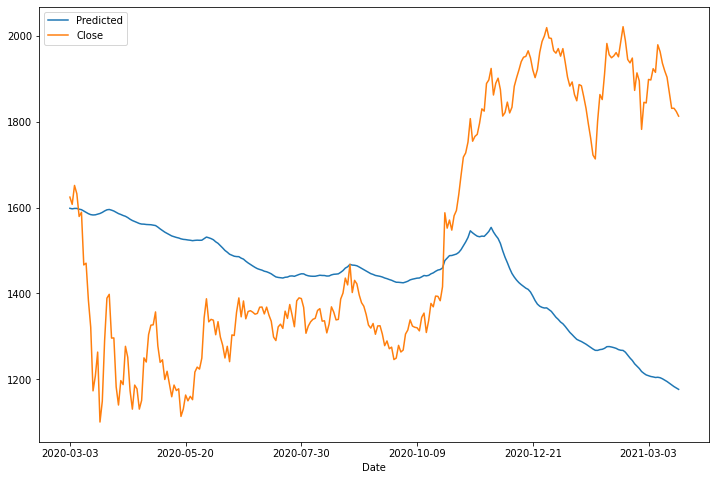

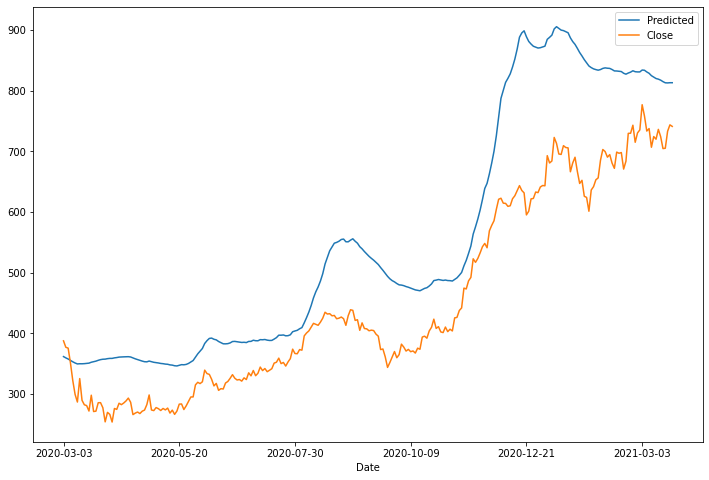

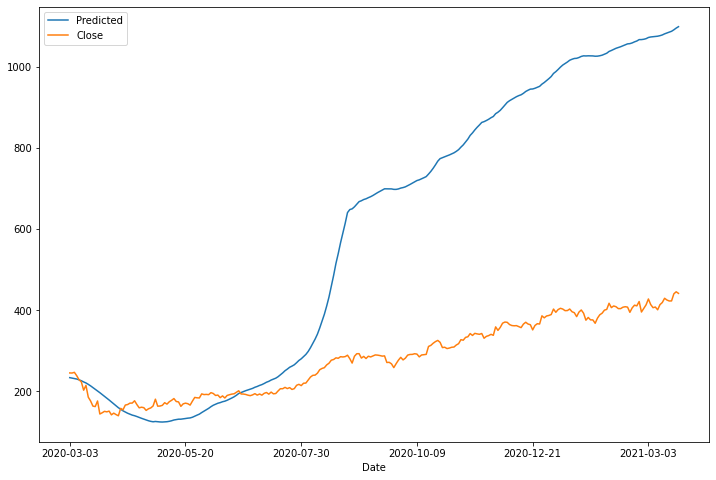

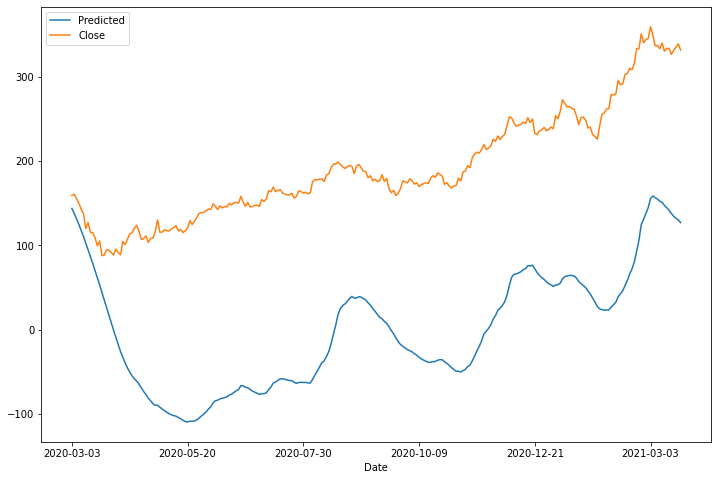

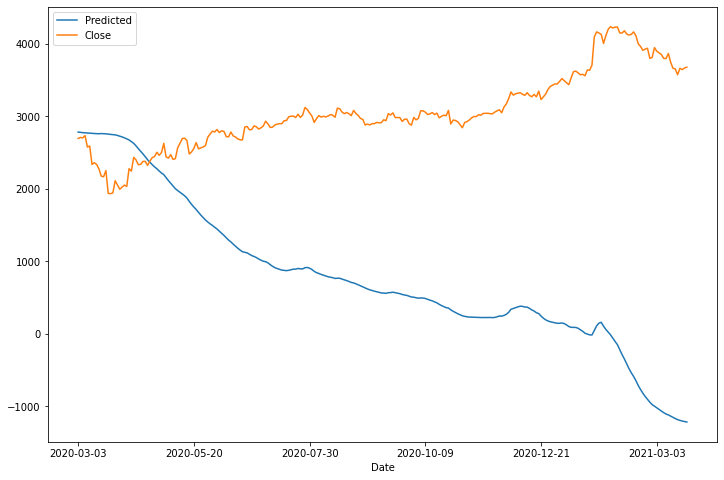

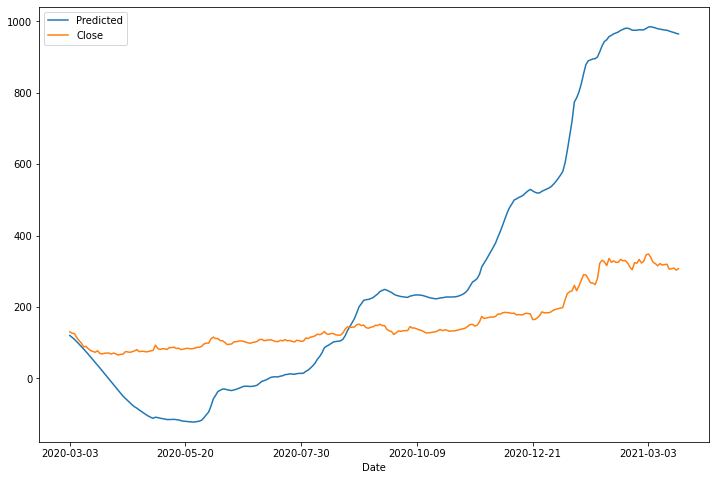

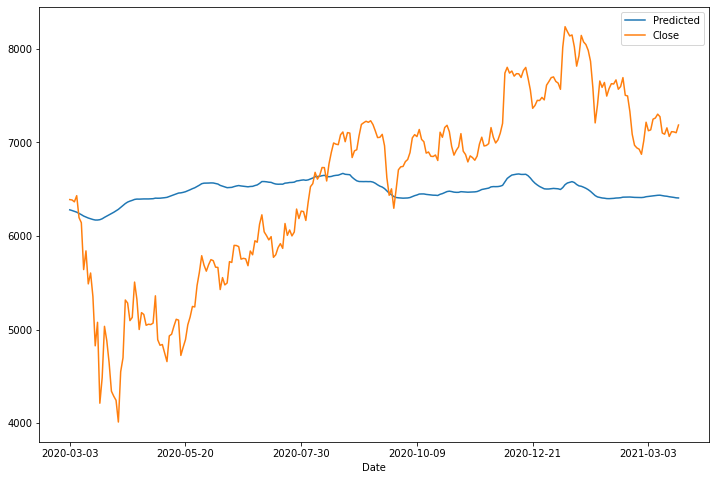

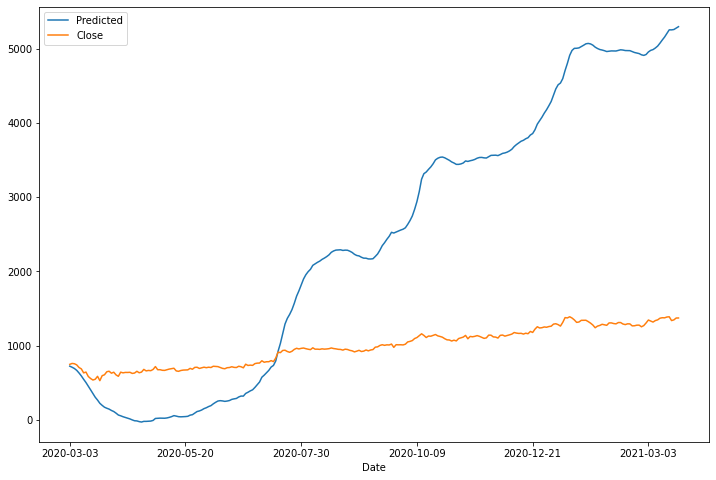

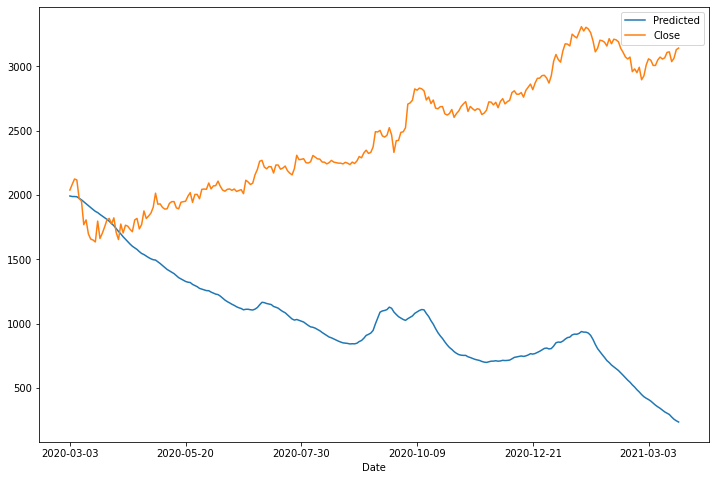

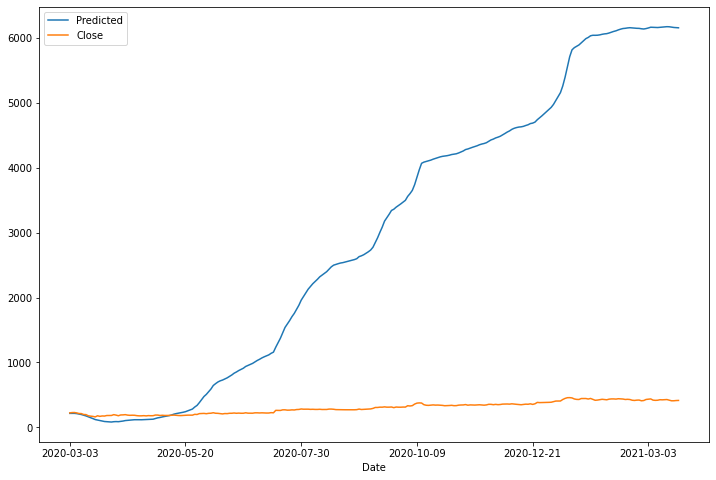

In [187]:
for stock in stocks:
    print("Working for Stock {}".format(stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Close'
    Order = CalculateAutoArimaForArimax(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
    ARIMAX_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults, Order=Order, train_data=train_data, test_data=test_data,extra_indicators = TechnicalIndicators )

In [188]:
ArimaModelPricesResults.to_csv('Outputs/ArimaModelPricesResults.csv')

## ARIMAX Normalized Closing Prices

In [189]:
ArimaxModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [190]:
ArimaxModelPricesResults_Norm

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Working for Stock BOM524715
Modeling for the Stock: BOM524715
ADF Test for the given series.
ADF test statistic                                 -4.80709
p-value                                         5.27124e-05
# lags used                                               0
#observations                                          4988
Stock Name              SUN PHARMACEUTICAL INDUSTRIES LTD. 
Stock Code                                        BOM524715
critical value (1%)                                -3.43166
critical value (5%)                                -2.86212
critical value (10%)                               -2.56708
dtype: object
----------------------------------------------------------------------------
const                        -0.091161
Normalized RSI                0.012062
Normalized ATR               -0.023624
Normalized MACD              -0.008242
Normalized ADX               -0.002625
Normalized OBV                0.000002
ma.L1.D.Normalized Closing    0.040559
dty

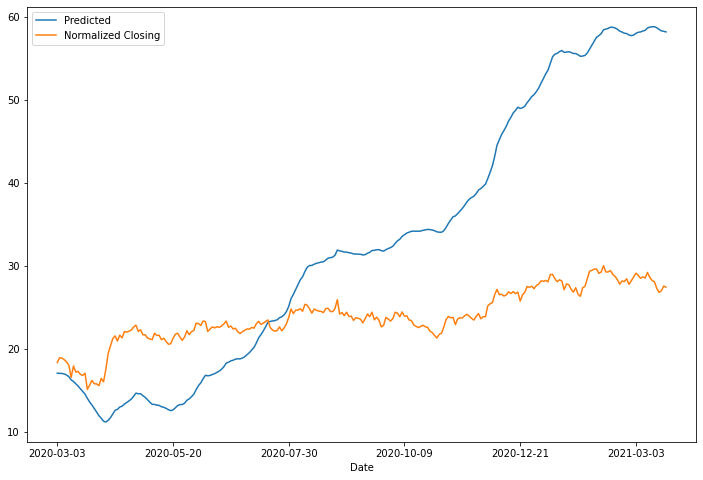

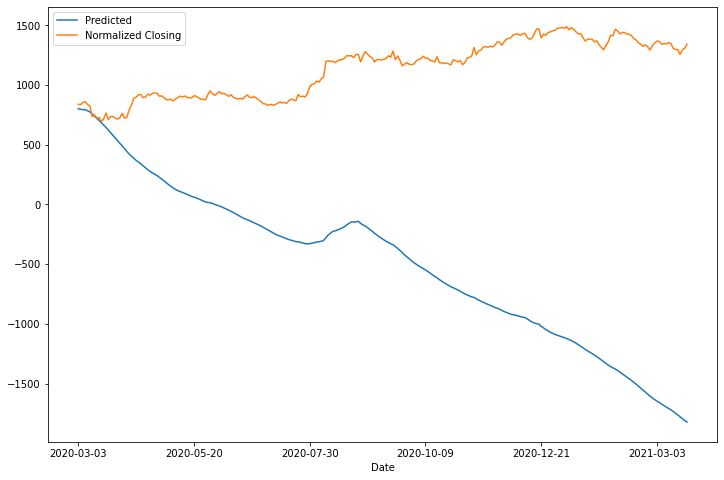

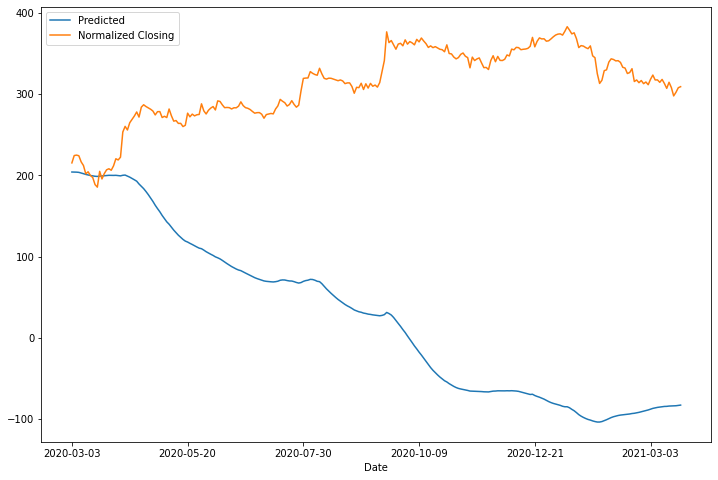

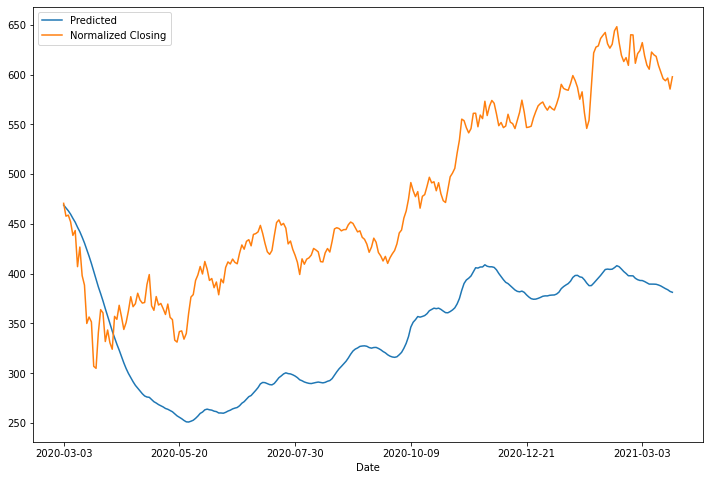

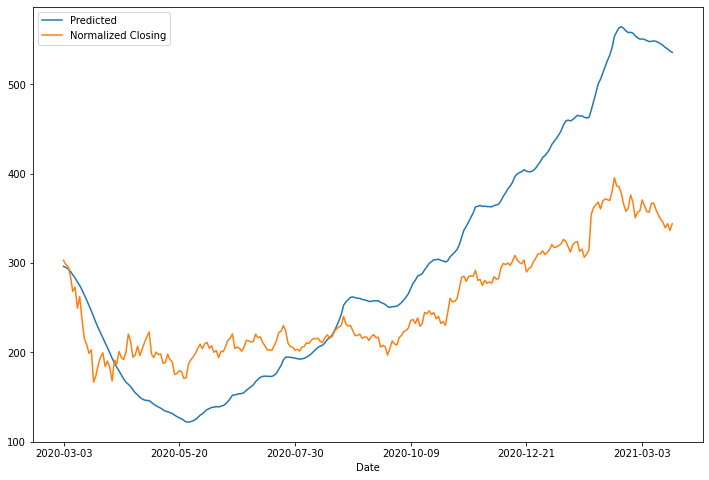

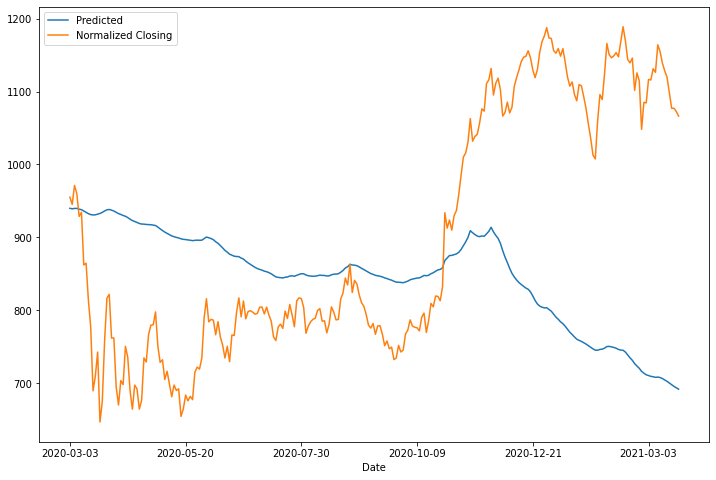

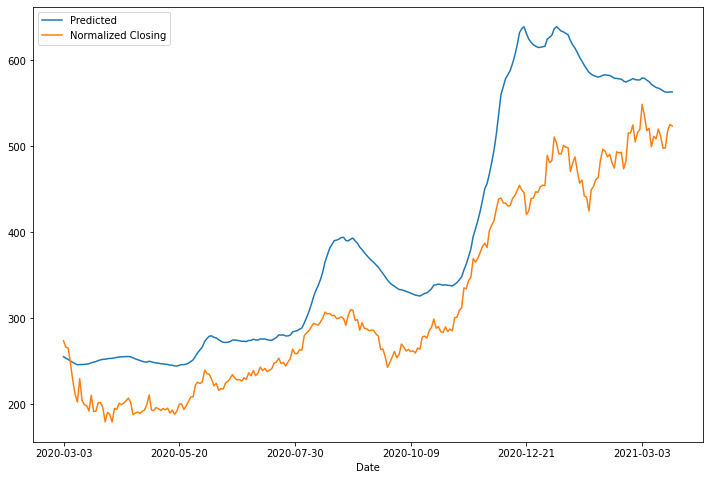

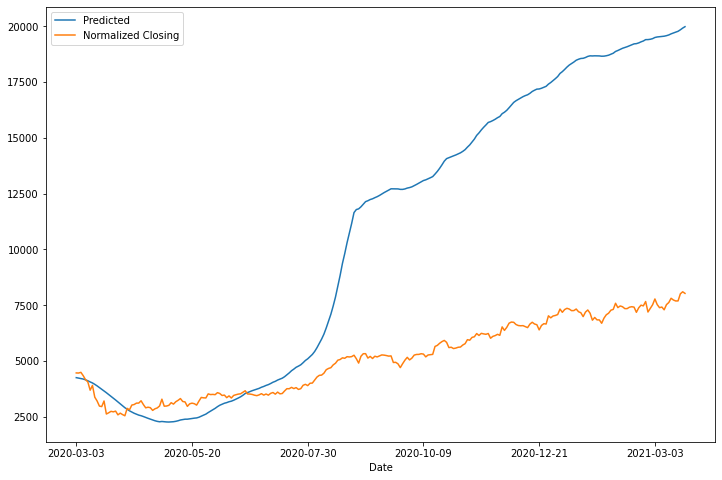

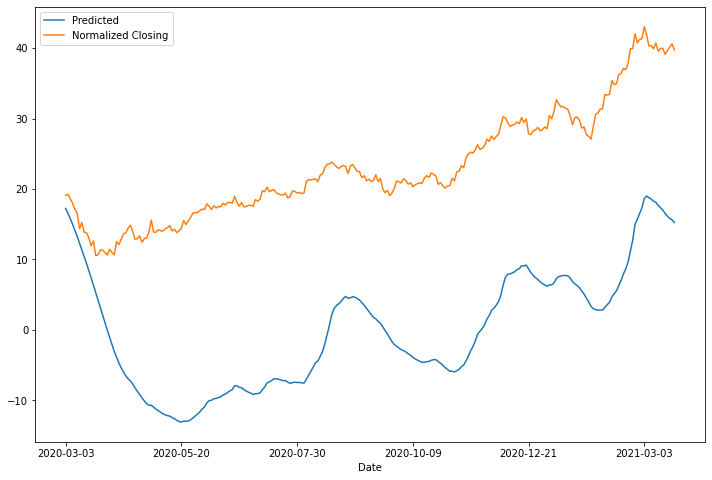

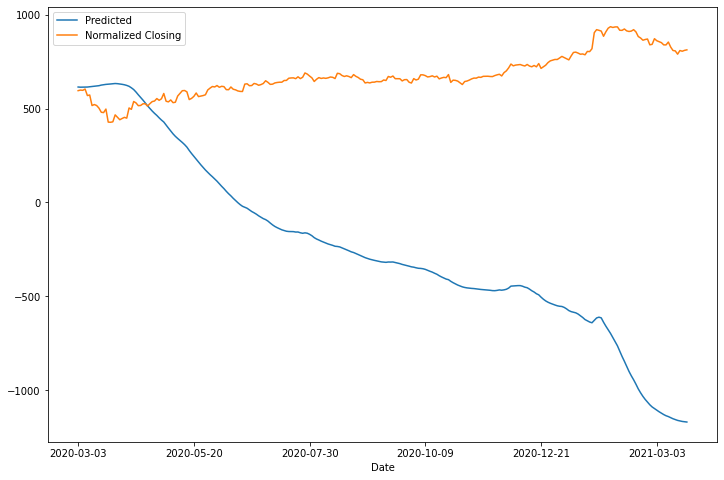

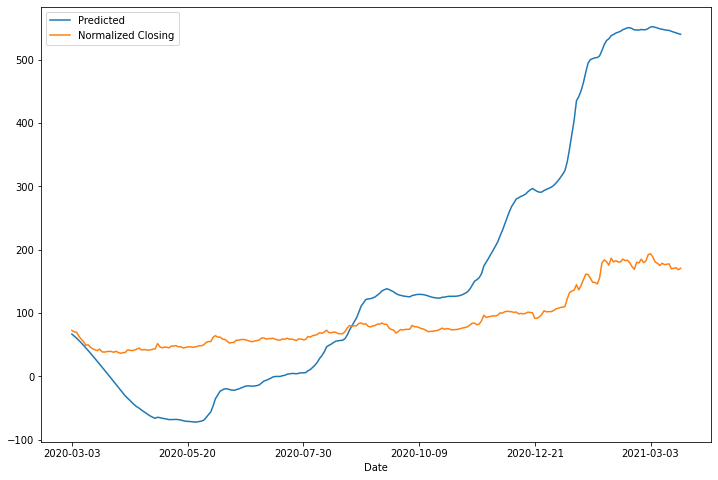

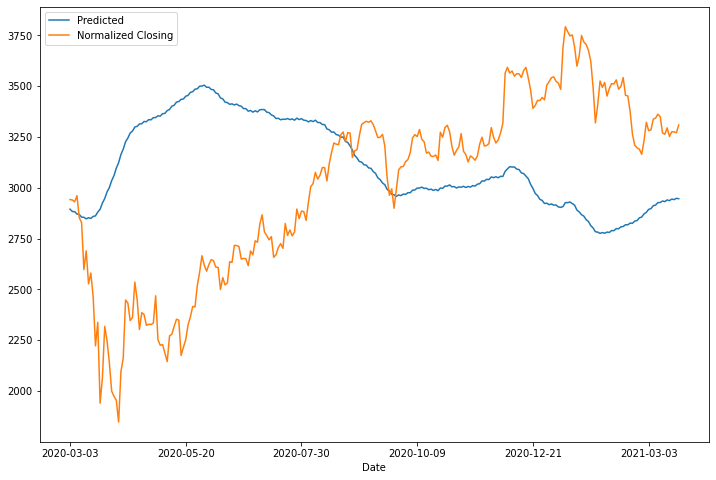

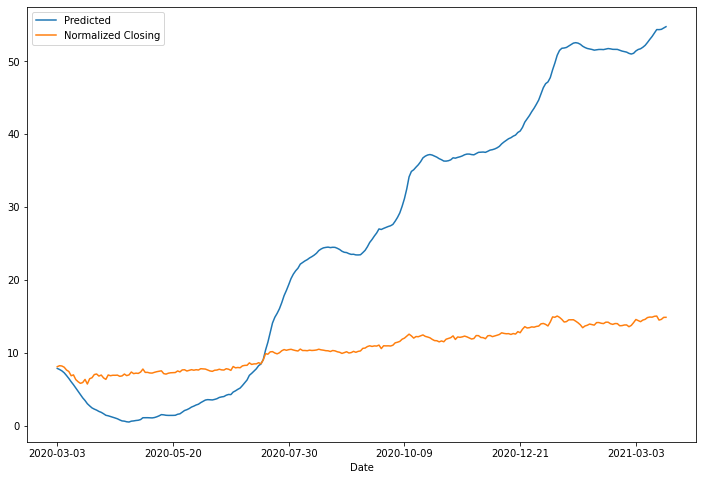

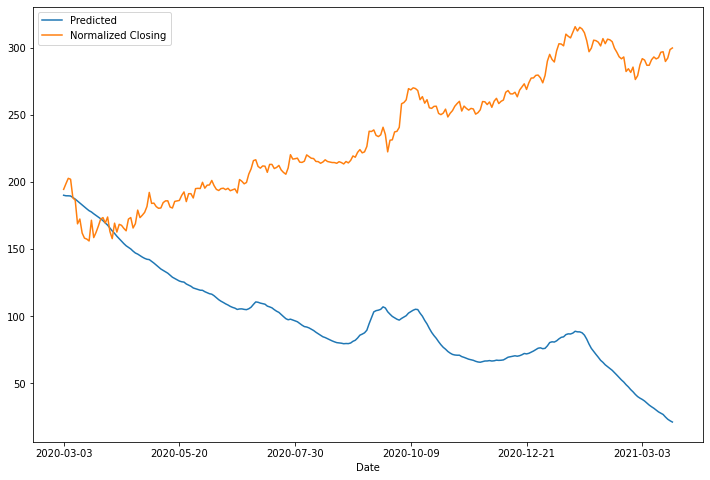

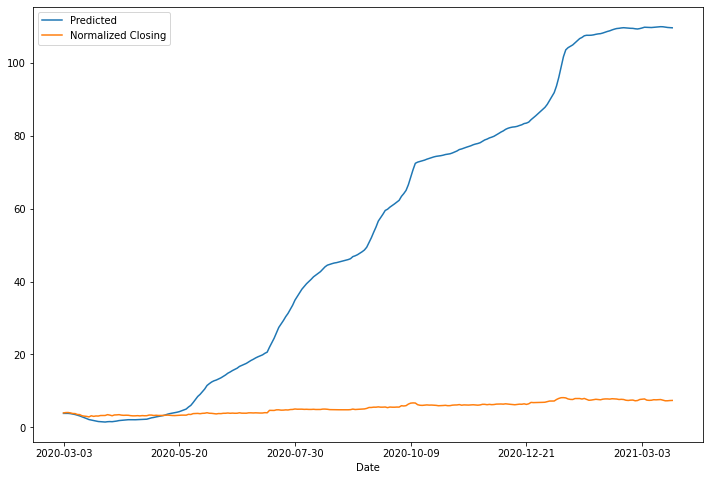

In [192]:
for stock in stocks:
  print("Working for Stock {}".format(stock))
  train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
  feature = 'Normalized Closing'
  Order = CalculateAutoArimaForArimax(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
  ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data,extra_indicators = normalized_TechnicalIndicators)

In [194]:
ArimaxModelPricesResults_Norm.to_csv('Outputs/ArimaxModelPricesResults_Norm.csv')

## ARIMAX Returns

In [193]:
ArimaxModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [197]:
ArimaxModelPricesResults_Returns

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,Stationary,"(1, 0, 2)",2.25913,1.89248,0.122771,0.252512,0.29385166583265226,0.20573864798210306
BOM532488,Stationary,"(3, 0, 1)",2.43923,7.21532,-0.0605381,0.24049,-0.6908502613092153,0.22024935679929103
BOM500124,Stationary,"(0, 0, 0)",2.4188,4.37077,-0.155384,0.28367,-0.7768185827582432,0.18088231861858162
BOM500180,Stationary,"(1, 0, 1)",2.52264,1.31286,0.0943411,0.200157,-0.052025210879718634,0.12566854955618048
BOM532174,Stationary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,Stationary,"(0, 0, 1)",2.76079,1.71073,0.102382,0.317418,-0.303082981511499,0.0901047802483421
BOM500470,Stationary,"(2, 0, 2)",2.99568,2.05554,0.0649594,0.439239,0.44060961096532425,0.3173045225208098
BOM500228,Stationary,"(0, 0, 0)",20.7521,19.5524,-43.5807,4.00153,6.328366493509867,0.2887804435159547
BOM500440,Stationary,"(2, 0, 2)",3.49094,2.40893,0.0929413,0.343924,0.2787123779922158,0.36871118873150094
BOM532977,Stationary,"(0, 0, 1)",2.52926,3.09303,-0.0788497,0.300841,-0.662632042405857,0.13360405849851478


Working for Stock BOM524715
Modeling for the Stock: BOM524715
ADF Test for the given series.
ADF test statistic                                 -50.2495
p-value                                                   0
# lags used                                               1
#observations                                          4987
Stock Name              SUN PHARMACEUTICAL INDUSTRIES LTD. 
Stock Code                                        BOM524715
critical value (1%)                                -3.43166
critical value (5%)                                -2.86212
critical value (10%)                               -2.56708
dtype: object
----------------------------------------------------------------------------
const                 -6.135111e-01
RSI                    1.532217e+00
ATR                   -2.180970e-02
MACD                  -1.383234e-02
adx                   -2.420459e-02
OBV                   -3.990258e-09
ar.L1.Stock_Returns    1.685769e-02
ma.L1.Stock_Returns    1

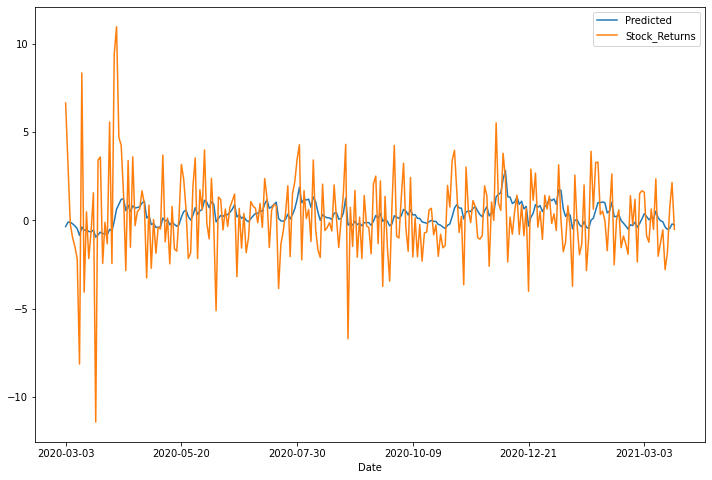

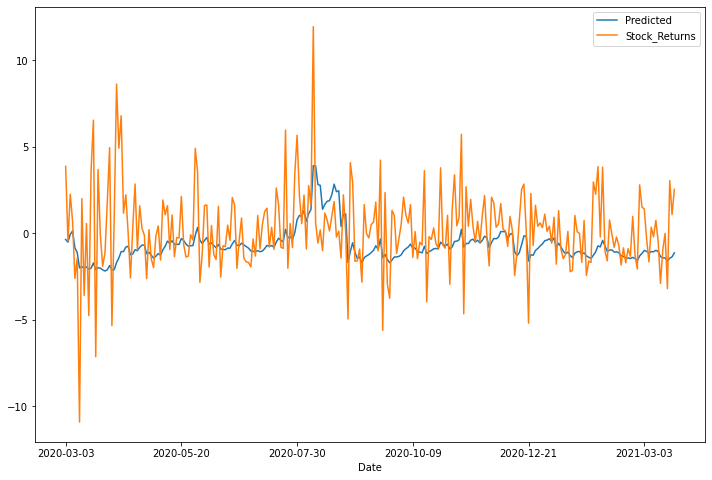

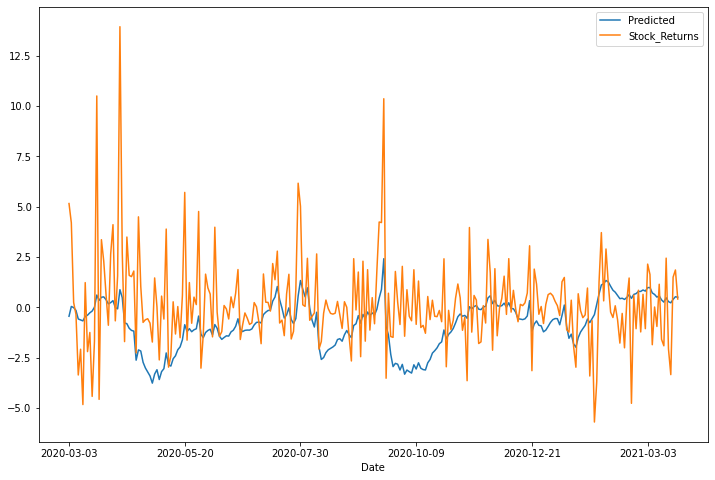

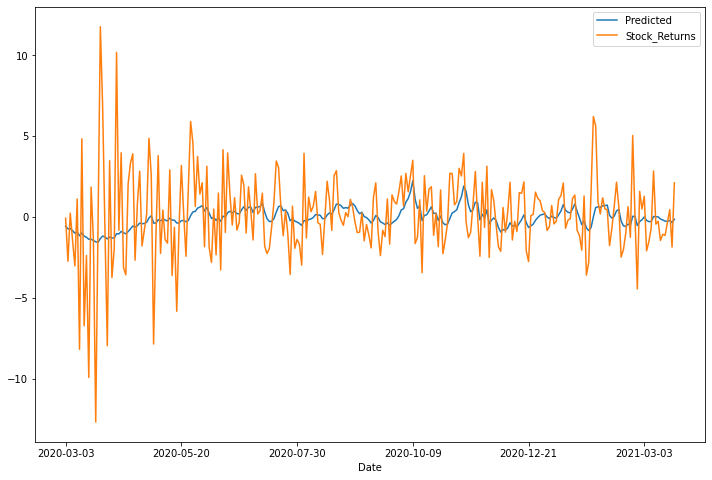

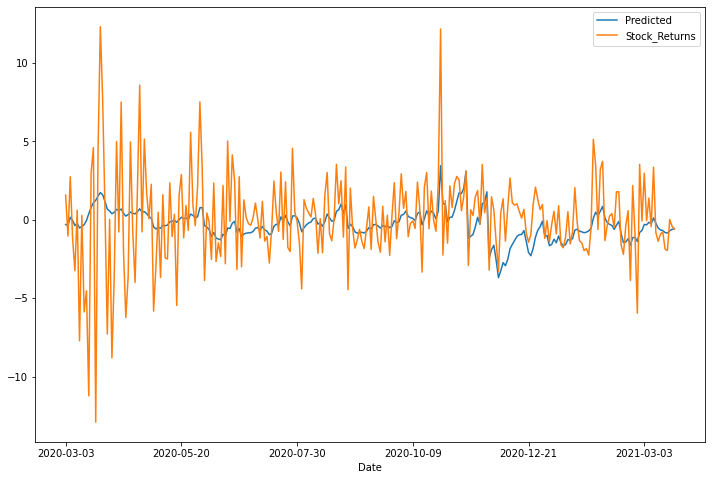

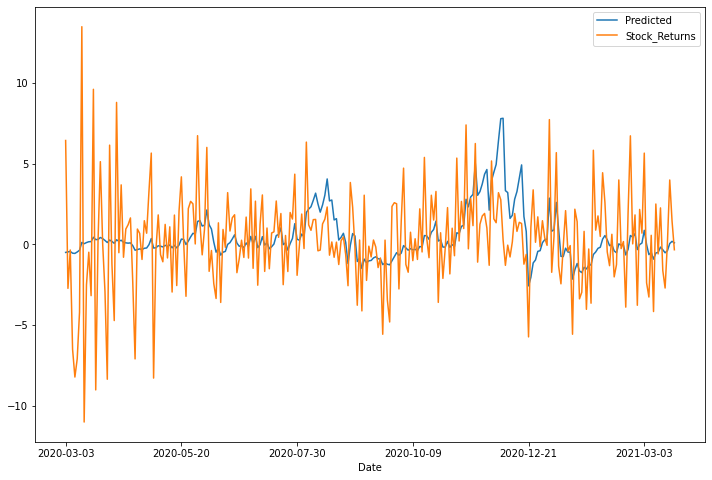

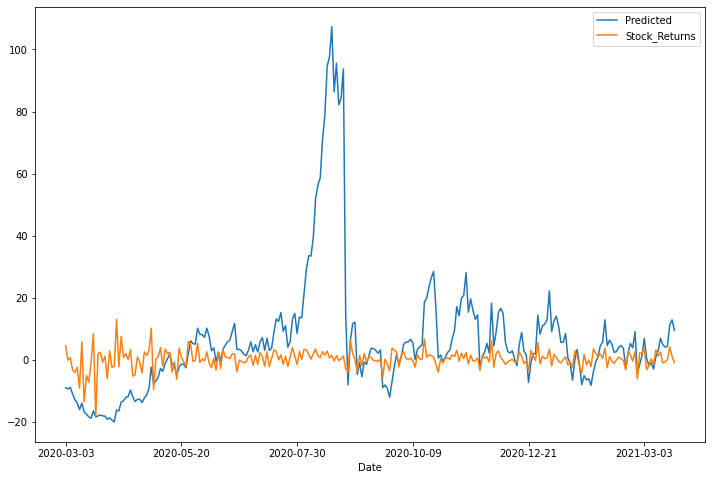

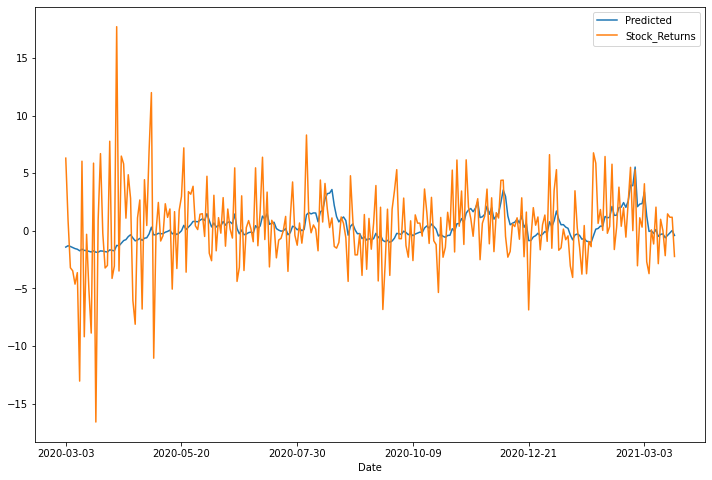

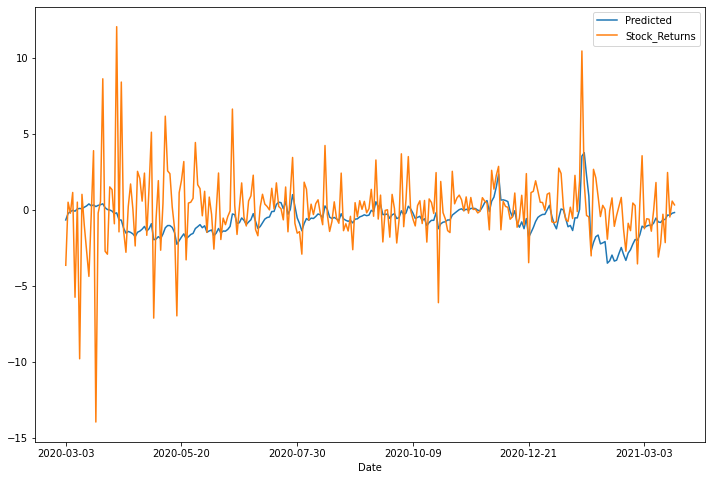

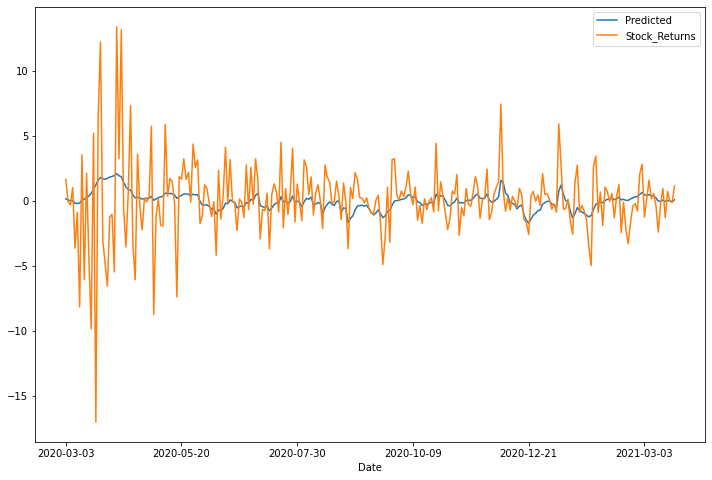

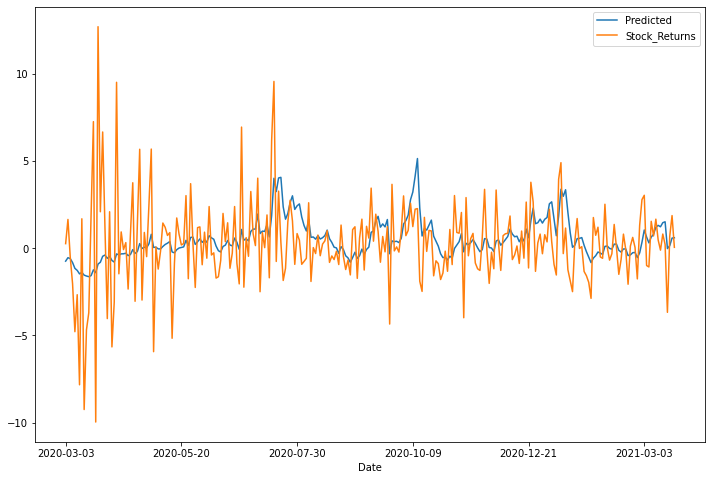

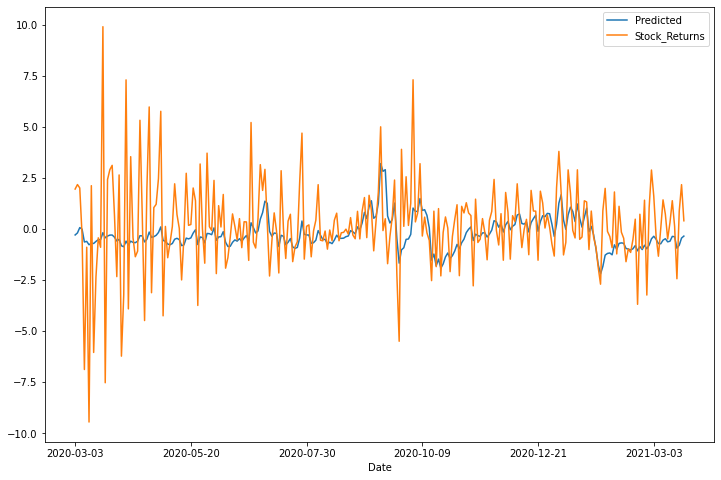

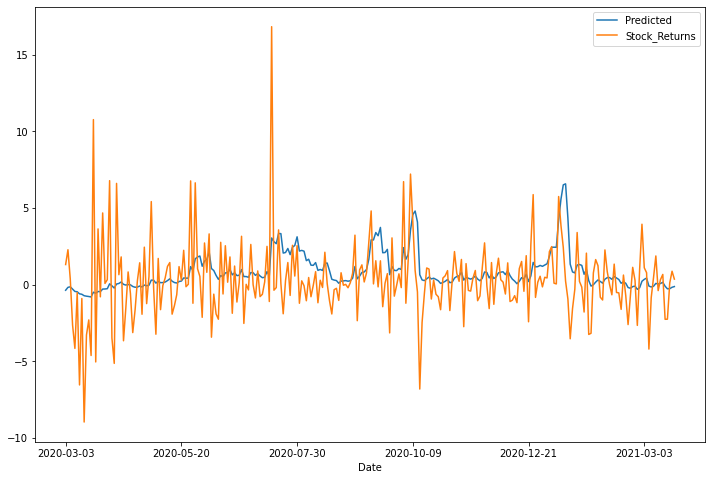

In [196]:
for stock in stocks:
    try:
        print("Working for Stock {}".format(stock))
        train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
        feature = 'Stock_Returns'
        Order = CalculateAutoArimaForArimax(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
        ARIMAX_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaxModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data, extra_indicators = TechnicalIndicators)
    except Exception as e:
        print(e)  

In [198]:
ArimaxModelPricesResults_Returns.to_csv('Outputs/ArimaxModelPricesResults_Returns.csv')

In [199]:
AutoArimaResults.to_csv('Outputs/AutoArimaResultsForArimax.csv')

# Code Finsih Tavish------------------------------------------------

# SARIMAX MODEL

In [ ]:
def SARIMAXProcedure(stockCode):
    # decompose
    data = ScriptWiseData  [stockCode]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('b')
    data = data.fillna(method='ffill')
    decompose_result = seasonal_decompose(data['Close'], model='add')
    
    r = auto_arima(data['Close'], exogenous=data[TechnicalIndicators], maxiter=1000) #seasonality, m parameters pending
    p, d, q = r.order # define for P, D, Q, S
        
    train, test = TrainTestSplitByDateRange(data)
    
    model = SARIMAX(train['Close'], exog = train[TechnicalIndicators] ,order = (p, d, q), seasonal_order = (1,1,1,2), enforce_invertibility = False)
    results = model.fit()
    predictions = results.predict(start_date, end_date, exog=test[TechnicalIndicators]).rename('SARIMA')
    
    return decompose_result, results, predictions

In [ ]:
decompose_result, model, predictions = SARIMAXProcedure(stocks[2])

### VARMAX MODEL

In [ ]:
ScriptWiseData[stocks[0]]

In [ ]:
def DifferenceToMakeStationary(data, n):
    data_transformed = data
    for i in range(n):
        data_transformed = data_transformed.diff()
    data_transformed = data_transformed.dropna()
    return data_transformed

In [ ]:
def InvertDifferencingForActualResults(data,data_differenced, forecast, column, order):
    df_forecast = forecast.copy()
    n = len(forecast)
    for i in range(order):
        tempColumn = f'{column}{i}'
        # Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
        df_forecast[tempColumn] = (data[column].iloc[-n-1]-data[column].iloc[-n-2]) + df_forecast[column].cumsum()
        # Now build the forecast values from the first difference set
        df_forecast['Forecast'] = df[column].iloc[-n-1] + df_forecast[tempColumn].cumsum()

In [ ]:
# Train and fit varmax model
def VARMAXProcedure(stockSymbol):
    data = ScriptWiseData[stockSymbol][['Close']+TechnicalIndicators] #.reset_index();
    data.index.freq = 'B'
    # determine values of p,d, q by auto arima.
    p, d, q = CalculateAutoArima(stockSymbol, ScriptWiseData[stockSymbol])
    
    # make data stationary based on auto arima output
    data_transformed = DifferenceToMakeStationary(data, d)
    
    # train test spllit  
    train, test = TrainTestSplitByDateRange(data_transformed)
    
    # fit the model based on above parameters
    model = VARMAX(train, order=(p,q))
    results = model.fit(maxiter=1000, disp=False)
    forecasts = results.forecast(len(test))
    
    #     forecasts = InvertDifferencingForActualResults()
    return results, forecasts

In [ ]:
# model, forecasts = VARMAXProcedure(stocks[0])

## Prophet models

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_start_date = pd.to_datetime(start_date)
df_end_date = pd.to_datetime(end_date)

In [ ]:
def ProphetProcedure(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode][['Close']]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y']
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
    m = Prophet()

    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
#     test_t = test.set_index('ds')
#     future = future.set_index('ds')
#     future = test_t[].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [ ]:
def ProphetProcedureWithExogenousVariables(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode][['Close']+TechnicalIndicators]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y'] + TechnicalIndicators
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
#     return df, 1
    m = Prophet()
    for t in TechnicalIndicators:
        m.add_regressor(t)
    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
    test_t = test.set_index('ds')
    future = future.set_index('ds')
    future = test_t[TechnicalIndicators].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [ ]:
# Hyper parameter tuning
# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [ ]:
# initalize result variable
ProphetSingleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
for s in stocks:
    print(s)
    try:
        m, forecast, df_cv = ProphetProcedure(s)
        val_metrics = performance_metrics(df_cv)
        ProphetSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        ProphetSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['mae'][0]
        ProphetSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['mse'][0])
        t = df_cv.dropna()
        ProphetSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat)
        ProphetSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat)
        ProphetSingleRegressionResults.loc[s, ['Noise']] = t.yhat.diff().abs().mean()
        print('Success')
    except:
        print("Error Occured", sys.exc_info())
        
ProphetSingleRegressionResults.to_csv('Outputs/ProphetSingleRegressionResults.csv')

In [ ]:
# initalize result variable
ProphetMultipleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
for s in stocks:
    print(s)
    # try:
    m, forecast, df_cv = ProphetProcedureWithExogenousVariables(s)
    val_metrics = performance_metrics(df_cv)
    ProphetMultipleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
    ProphetMultipleRegressionResults.loc[s, ['MAE']] =  val_metrics['mae'][0]
    ProphetMultipleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['mse'][0])
    t = df_cv.dropna()
    ProphetMultipleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat)
    ProphetMultipleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat)
    ProphetMultipleRegressionResults.loc[s, ['Noise']] = t.yhat.diff().abs().mean()
    print('Success')
    # except:
    #     print("Error Occured", sys.exc_info())
        
ProphetMultipleRegressionResults.to_csv('Outputs/ProphetMultipleRegressionResults.csv')

In [ ]:
# for plotting
df = ScriptWiseData[stocks[1]]
df.index = pd.to_datetime(df.index)
df = df.reset_index()
df.columns = ['ds', 'y'] + TechnicalIndicators

In [ ]:
results = performance_metrics(df_cv)
results.head(2)

In [ ]:
m.plot_components(forecast);

In [ ]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

df.plot(x='ds',y='y',label='Actual Price',legend=True,ax=ax) #,xlim=(df_start_date,df_end_date))

In [ ]:
plot_cross_validation_metric(df_cv, metric='rmse');

## Neural Prophet and AR-Net

In [ ]:
from neuralprophet import NeuralProphet, set_random_seed , set_log_level
set_random_seed(0)
set_log_level("ERROR")

In [ ]:
df = ScriptWiseData['BOM500180'].reset_index()
df = df[['Date', 'Close']]
df.columns = ['ds', 'y']
df.head()

### Basic Model

In [ ]:
def BuildNeuralProphetModels(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5, columnName = 'Close'):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', columnName]]
    df.columns = ['ds', 'y']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D', progress_bar = False)
    val_metrics = m.test(df_val)
    
    # make forecasts
    future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
#     future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
# NPSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
# NPSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
# NPSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
# t = forecast.dropna()
# NPSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
# NPSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
# NPSingleRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()

In [ ]:
# initalize result variable
NPSingleRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
for s in stocks:
    print(s)
    try:
        m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData[s])
        NPSingleRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        NPSingleRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
        NPSingleRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
        t = forecast.dropna()
        NPSingleRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
        NPSingleRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
        NPSingleRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()
        print('Success')
    except:
        print("Error Occured")
        
NPSingleRegressionResults.to_csv('Outputs/Neural Prophet Single Regression Results.csv')

In [ ]:
NPSingleRegressionResults

#### Plot the forecast

In [ ]:
# forecasts_plot = m.plot(forecast)

In [ ]:
# fig_comp = m.plot_components(forecast);

In [ ]:
# fig_param = m.plot_parameters()

#### Validating the dataset

In [ ]:
# m = NeuralProphet()
# df_train, df_val = m.split_df(df, valid_p=0.2, freq='D')

In [ ]:
# train_metrics = m.fit(df_train, freq='D')
# val_metrics = m.test(df_val)

## Multiple regressors

In [ ]:
def BuildNeuralProphetModelsWithMultipleRegressors(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', 'Close']+TechnicalIndicators]
    df.columns = ['ds', 'y', 'A', 'B', 'C', 'D', 'E']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    # lagged regressors
    m.add_lagged_regressor(name='A')
    m.add_lagged_regressor(name='B')
    m.add_lagged_regressor(name='C')
    m.add_lagged_regressor(name='D')
    m.add_lagged_regressor(name='E')
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D',progress_bar = False)
    val_metrics = m.test(df_val)
    
    # make forecasts
    # future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
    future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
# m, forecast , train_metrics, val_metrics = BuildNeuralProphetModelsWithMultipleRegressors(ScriptWiseData[stocks[0]])

In [ ]:
# initalize result variable
NPExogenousRegressionResults = pd.DataFrame(columns = ['StockName','MAE','MAPE', 'RMSE', 'AdjustedR2', 'Noise'], index = stocks)
for s in stocks:
    print(s)
    try:
        m, forecast , train_metrics, val_metrics = BuildNeuralProphetModelsWithMultipleRegressors(ScriptWiseData[s])
        NPExogenousRegressionResults.loc[s, ['StockName']] =  getStockNameFromStockCode(s)
        NPExogenousRegressionResults.loc[s, ['MAE']] =  val_metrics['MAE'][0]
        NPExogenousRegressionResults.loc[s, ['RMSE']] = np.sqrt(val_metrics['MSE'][0])
        t = forecast.dropna()
        NPExogenousRegressionResults.loc[s, ['MAPE']] = mean_absolute_percentage_error(t.y, t.yhat1)
        NPExogenousRegressionResults.loc[s, ['AdjustedR2']] = r2_score(t.y, t.yhat1)
        NPExogenousRegressionResults.loc[s, ['Noise']] = t.yhat1.diff().abs().mean()
        print('Success')
    except:
        print("Error Occured")
        
NPExogenousRegressionResults.to_csv('Outputs/Neural Prophet Regression With Exogenous Variables Results.csv')

In [ ]:
NPExogenousRegressionResults

In [ ]:
# # m = NeuralProphet()
# # metrics = m.fit(df, freq="D")
# for s in stocks:
#     print(s)
#     try:
#         m, forecast , train_metrics, val_metrics = BuildNeuralProphetModelsWithMultipleRegressors(ScriptWiseData[s])
# #         m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData[s])
#         print('Succeess')
#     except:
#         print("Error Occured")

In [ ]:
# forecasts_plot = m.plot(forecast)
# fig_comp = m.plot_components(forecast)

In [ ]:
# train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [False, False]).head(3)

In [ ]:
# train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [True, True]).head(3)

In [ ]:
# val_metrics